In [15]:
#importing necessary libraries
from api.mapbox_api_walking import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod

In [2]:
#reading in library branch and population demographics, both with geometry data
branchInfo = gpd.read_file('../data/clean/branches.csv')
censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [4]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [5]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


In [6]:
#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary,key):
   
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            #print(propOverlap)
            dictionary[df.loc[i, key]] = propOverlap
    return dictionary
   

In [7]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [8]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary
#travelTime = an integer of the amount of time traveled you wish to calculate the isochrone

def appendADS(cdf,idf,scoreString,dictString,cgs,igs,lat,lon,key,travelTime):
    
    api = MapboxAPI()
    cdf[scoreString] = 0.0
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas



    for i in range(len(idf)):
        dictionary = {}
        api_response =  api.get_data((idf.loc[i,lat],idf.loc[i,lon]), travelTime)
        idf.loc[i,igs] = shape(api_response)
        dictionary = check(idf.loc[i,igs],cdf,cgs, dictionary,key)
        branchInfo.loc[i,dictString]= [dictionary]
    
        for i in range(len(cdf)):
   
            if dictionary.get(cdf.loc[i, key]) != None:
                score = cdf.loc[i, scoreString]
                cdf.loc[i, scoreString] = score + dictionary.get(cdf.loc[i, key])
  
          

In [9]:
appendADS(censusTracts,branchInfo, 'score', 'list of dict','geometry','geometry','LATITUDE','LONGITUDE','geoid',5)

KeyError: 'features'

api = MapboxAPI()
censusTracts['score'] = 0.0
branchInfo['dictionary'] = ''
censusAreas = []
#geod = Geod(ellps='WGS84')
censusTracts = censusTracts.set_crs('EPSG:4326')
branchInfo = branchInfo.set_crs('EPSG:4326')
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


for index, row in censusTracts.iterrows():
    poly_area, poly_perimeter = geod.geometry_area_perimeter(row['geometry'])
    poly_area = poly_area*-1
    censusAreas.append(poly_area)
censusTracts['calculated area'] = censusAreas



for i in range(len(branchInfo)):
    dictionary = {}
    api_response =  api.get_data((branchInfo.loc[i,'LATITUDE'],branchInfo.loc[i,'LONGITUDE']), 5)
    branchInfo.loc[i,'geometry'] = shape(api_response)
    dictionary = check(branchInfo.loc[i,'geometry'],censusTracts,'geometry', dictionary)
    branchInfo.loc[i,'dictionary']= [dictionary]
    
    for i in range(len(censusTracts)):
   
        if dictionary.get(censusTracts.loc[i, 'geoid']) != None:
            score = censusTracts.loc[i, 'score']
            censusTracts.loc[i, 'score'] = score + dictionary.get(censusTracts.loc[i, 'geoid'])
  
          

In [ ]:
branchInfo

In [10]:
censusTracts.sort_values(by = 'score', ascending = False)

,geoid,qualifying name,geometry,score,Area
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.72096 41.68395, -87.72030 41.683...",0.0,1.081697e+00
584,17031180100,"Census Tract 1801, Cook County, Illinois","POLYGON ((-87.80602 41.93801, -87.80550 41.938...",0.0,1.068355e+06
573,17031190602,"Census Tract 1906.02, Cook County, Illinois","POLYGON ((-87.77572 41.93114, -87.77499 41.931...",0.0,6.213532e+05
574,17031190800,"Census Tract 1908, Cook County, Illinois","POLYGON ((-87.75593 41.93140, -87.75445 41.931...",0.0,6.613179e+05
575,17031190900,"Census Tract 1909, Cook County, Illinois","POLYGON ((-87.74634 41.93154, -87.74625 41.931...",0.0,3.146358e+05
...,...,...,...,...,...
293,17031611400,"Census Tract 6114, Cook County, Illinois","POLYGON ((-87.67463 41.80851, -87.67440 41.808...",0.0,3.266192e+05
294,17031611300,"Census Tract 6113, Cook County, Illinois","POLYGON ((-87.66958 41.80856, -87.66885 41.808...",0.0,3.270306e+05
295,17031611200,"Census Tract 6112, Cook County, Illinois","POLYGON ((-87.66473 41.80861, -87.66434 41.808...",0.0,3.270397e+05
296,17031612200,"Census Tract 6122, Cook County, Illinois","POLYGON ((-87.65986 41.80867, -87.65914 41.808...",0.0,8.980825e+05


Text(0.5, 1.0, 'Percent of Coverage')

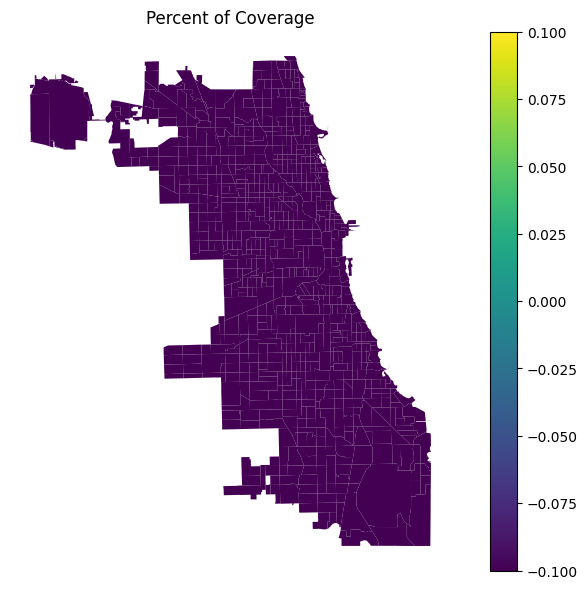

In [11]:
ax = censusTracts.plot(column = 'score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of Coverage")

In [12]:
censusTracts['score'].mean()

0.0